In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10

In [14]:
unusuals_df = pd.read_csv("CompleteHatAndPricingData.csv")
unusuals_df = unusuals_df[unusuals_df.columns.drop("Unnamed: 0")]
unusuals_train_df = unusuals_df[~unusuals_df["Price"].isnull()]

In [16]:
predictions_df = pd.read_csv("Predictions.csv")
predictions_df = predictions_df[predictions_df.columns.drop("Unnamed: 0")]

In [48]:
%%capture --no-stdout
unusuals_train_df["Estimate"] = "Actual Price"
predictions_df["Estimate"] = "Predicted Price"
complete_unusuals_df = pd.concat([unusuals_train_df,predictions_df],axis = 0)

In [269]:
complete_unusuals_df

,Class,Crate Cosmetic,Effect,Effect Community Rating,Effect Median Price,Effect Rating,Equip Region,Estimate,Generation,Grade,Hat Median Price,Hat Rating,Item Type,Median Effect Rating,Median Hat Rating,Months Since Last Price Update,Name,Price,Robo,Unboxed From
0,Heavy,True,Burning Flames,4.59375,104.00,1.6,Regular,Actual Price,First Gen,No Grade,14.0,-7.40,Cosmetic,6.7375,-1.6000,9,Dread Knot,30.000000,False,Old Series
2,Heavy,True,Circling Peace Sign,2.21875,22.00,-0.4,Regular,Actual Price,First Gen,No Grade,14.0,-1.20,Cosmetic,-0.8500,-1.6000,21,Dread Knot,10.000000,False,Old Series
3,Heavy,True,Circling TF Logo,2.34375,21.50,-0.5,Regular,Actual Price,First Gen,No Grade,14.0,-1.25,Cosmetic,-0.9125,-1.6000,44,Dread Knot,9.000000,False,Old Series
4,Heavy,True,Green Confetti,1.40625,17.00,-0.5,Regular,Actual Price,First Gen,No Grade,14.0,-0.80,Cosmetic,-1.3750,-1.6000,15,Dread Knot,9.000000,False,Old Series
5,Heavy,True,Green Energy,4.15625,50.00,0.1,Regular,Actual Price,First Gen,No Grade,14.0,-3.50,Cosmetic,1.8375,-1.6000,15,Dread Knot,15.000000,False,Old Series
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24688,Medic,False,Magnetic Hat Protector,2.15625,20.50,NaN,Regular,Predicted Price,Invasion,Mercenary,22.0,NaN,Cosmetic,-0.9000,-0.1625,-1,Snowcapped,19.998430,False,Winter 2018 Cosmetic
24689,Medic,False,Voltaic Hat Protector,2.09375,52.50,NaN,Regular,Predicted Price,Invasion,Mercenary,22.0,NaN,Cosmetic,-1.1750,-0.1625,-1,Snowcapped,18.809652,False,Winter 2018 Cosmetic
24690,Medic,False,Galactic Codex,1.43750,36.75,NaN,Regular,Predicted Price,Invasion,Mercenary,22.0,NaN,Cosmetic,-1.1000,-0.1625,-1,Snowcapped,20.512939,False,Winter 2018 Cosmetic
24691,Medic,False,Ancient Codex,1.46875,19.50,NaN,Regular,Predicted Price,Invasion,Mercenary,22.0,NaN,Cosmetic,-1.2500,-0.1625,-1,Snowcapped,17.228928,False,Winter 2018 Cosmetic


## Simulating Unboxing 

In [332]:
def simulate_unboxing(crate_name,halloween = False,reps = 1000000,crate_price = 0.05,key_price = 2.50):
    
    if halloween:
        effect_generations_for_simulation = ["Halloween 2011","Halloween 2012","Halloween 2013","Halloween 2014","Halloween 2016","Halloween 2018"]
        taunt_generations_for_simulation = ["Halloween 2014","Halloween 2016","Halloween 2018"]
    else:
        effect_generations_for_simulation = ["First Gen","Second Gen","Third Gen"]
        taunt_generations_for_simulation = ["Love & War"]
        
    grades = True

    if "Crate" in crate_name:
        grades = False
        if halloween:
            effect_generations_for_simulation = ["First Gen","Second Gen","Third Gen"]
    elif "Old Series" in crate_name:
        grades = False
        if halloween:
            effect_generations_for_simulation = ["First Gen","Second Gen","Third Gen"]
    elif "End of the Line" in crate_name:
        grades = False
        effect_generations_for_simulation = ["End of the Line"]
        crate_name = "Old Series"
    elif "Robotic Boogaloo" in crate_name:
        grades = False
        effect_generations_for_simulation = ["Robotic Boogaloo"]
        crate_name = "Old Series"
    
    extra_effects_map = ({"Confidential Collection" : "Invasion","Quarantined Collection" : "Invasion", "Gargoyle" : "Halloween 2015",
                        "Creepy Crawley" : "Halloween 2016","Violet Vermin" : "Halloween 2018"})
    if crate_name in extra_effects_map:
        if extra_effects_map[crate_name] not in effect_generations_for_simulation:
            effect_generations_for_simulation.append(extra_effects_map[crate_name])
        
        
    if crate_name == "Old Series":
        possible_unboxes_df = pd.DataFrame()
        for generation in effect_generations_for_simulation:
            to_add = complete_unusuals_df[(complete_unusuals_df["Generation"] == generation) & (complete_unusuals_df["Crate Cosmetic"])]
            possible_unboxes_df = pd.concat([possible_unboxes_df,to_add],axis = 0)
    else:   
        possible_unboxes_df = pd.DataFrame()
        for generation in effect_generations_for_simulation:
            to_add = complete_unusuals_df[(complete_unusuals_df["Generation"] == generation) & (complete_unusuals_df["Unboxed From"] == crate_name)]
            possible_unboxes_df = pd.concat([possible_unboxes_df,to_add],axis = 0)
                                             
    hat_unbox_prices = []
    
    num_hats_unboxed = 0
    num_taunts_unboxed = 0
    
    average_hat_unbox_value = 0
    average_taunt_unbox_value = 0
    
    money_spent = key_price * reps + crate_price * reps
    money_earned = 0
    
    if(grades):
        
        taunt_unbox_prices = []
        
        possible_taunt_unboxes_df = pd.DataFrame()
        for generation in taunt_generations_for_simulation:
            to_add = complete_unusuals_df[(complete_unusuals_df["Generation"] == generation) & (complete_unusuals_df["Unboxed From"] == "Unusualifier")]
            possible_taunt_unboxes_df = pd.concat([possible_taunt_unboxes_df,to_add],axis = 0)
        
        mercenary_percent = 79.92327 + 0.25575
        commando_percent = mercenary_percent + 15.98465
        assassin_percent = commando_percent + 3.19693
        elite_percent = assassin_percent + 0.63939
        
        mercenary_prices = np.array(possible_unboxes_df[possible_unboxes_df["Grade"] == "Mercenary"]["Price"])
        commando_prices = np.array(possible_unboxes_df[possible_unboxes_df["Grade"] == "Commando"]["Price"])
        assassin_prices = np.array(possible_unboxes_df[possible_unboxes_df["Grade"] == "Assassin"]["Price"])
        elite_prices = np.array(possible_unboxes_df[possible_unboxes_df["Grade"] == "Elite"]["Price"])
        
        taunt_prices = np.array(possible_taunt_unboxes_df["Price"])
        
        if len(commando_prices) <= 0:
            commando_prices = mercenary_prices
        if len(assassin_prices) <= 0:
            assassin_prices = mercenary_prices
        if len(elite_prices) <= 0:
            elite_prices = mercenary_prices
        
        for unbox in range(0,reps):
            hat_opened = random.randint(0,100)
            taunt_opened = random.randint(0,100)
            
            if hat_opened == 1: #unusual unboxed
                res = random.uniform(0,100)
                num_hats_unboxed = num_hats_unboxed + 1

                if res <= mercenary_percent:
                    #mercenary grade
                    random_number = random.randint(0,len(mercenary_prices)-1)
                    hat_unbox_prices.append(mercenary_prices[random_number])

                elif res <= commando_percent:
                    #commando grade
                    random_number = random.randint(0,len(commando_prices)-1)
                    hat_unbox_prices.append(commando_prices[random_number])

                elif res <= assassin_percent:
                    #assassin grade
                    random_number = random.randint(0,len(assassin_prices)-1)
                    hat_unbox_prices.append(assassin_prices[random_number])

                elif res <= elite_percent:
                    #elite grade
                    random_number = random.randint(0,len(elite_prices)-1)
                    hat_unbox_prices.append(elite_prices[random_number])
                        
            if taunt_opened == 1: #taunt unboxed
                
                num_taunts_unboxed = num_taunts_unboxed + 1
                
                random_number = random.randint(0,len(taunt_prices)-1)
                taunt_unbox_prices.append(taunt_prices[random_number])
                
        if num_hats_unboxed != 0:
            money_earned = money_earned + np.array(hat_unbox_prices).sum() * key_price
            average_hat_unbox_value = np.array(hat_unbox_prices).sum()/num_hats_unboxed
        if num_taunts_unboxed != 0:
            money_earned = money_earned + np.array(taunt_unbox_prices).sum() * key_price
            average_taunt_unbox_value = np.array(taunt_unbox_prices).sum()/num_taunts_unboxed
        return average_hat_unbox_value, average_taunt_unbox_value,num_hats_unboxed,num_taunts_unboxed,(money_earned-money_spent)/reps
        
    else:
        no_grade_prices = np.array(possible_unboxes_df[possible_unboxes_df["Grade"] == "No Grade"]["Price"])
        
        for unbox in range(0,reps):
            hat_opened = random.randint(0,100)
            
            if hat_opened == 1: #hat unboxed
                num_hats_unboxed = num_hats_unboxed + 1

                random_number = random.randint(0,len(no_grade_prices)-1)
                hat_unbox_prices.append(no_grade_prices[random_number])
                
        if num_hats_unboxed != 0:
            money_earned = money_earned + np.array(hat_unbox_prices).sum() * key_price
            average_hat_unbox_value = np.array(hat_unbox_prices).sum()/num_hats_unboxed
        return average_hat_unbox_value,np.nan,num_hats_unboxed,np.nan,(money_earned-money_spent)/reps

        
    return possible_unboxes_df

In [321]:
crates = complete_unusuals_df[["Crate Cosmetic","Unboxed From"]]
crates = list(crates["Unboxed From"].unique())
crates.remove("Unusualifier")
crates.remove("Not Unboxable")
crates.append("End of the Line")
crates.append("Robotic Boogaloo")
crates

['Old Series',
 'Multi/All Crate',
 'Demoman Crate',
 'Engineer Crate',
 'Heavy Crate',
 'Soldier Crate',
 'Spy Crate',
 'Pyro Crate',
 'Medic Crate',
 'Scout Crate',
 'Sniper Crate',
 'Gun Mettle Cosmetic',
 'Confidential Collection',
 'Quarantined Collection',
 'Gargoyle',
 'Tough Break Cosmetic',
 'Mayflower Cosmetic',
 'Creepy Crawly',
 'Unlocked Winter 2016 Cosmetic',
 'Rainy Day Cosmetic',
 'Abominable Cosmetic',
 'Unleash the Beast Cosmetic',
 'Winter 2017 Cosmetic',
 'Blue Moon Cosmetic',
 'Violet Vermin',
 'Winter 2018 Cosmetic',
 'End of the Line',
 'Robotic Boogaloo']

## Results that Answer the Research Question

In [322]:
results = []

for crate in crates:
    unboxing_result = simulate_unboxing(crate)
    results.append([crate,unboxing_result[0],unboxing_result[1],unboxing_result[2],unboxing_result[3],unboxing_result[4]])
                   
unboxing_df = pd.DataFrame(results)

In [323]:
unboxing_df =unboxing_df.rename(columns={0: "Crate/Case Name",1:"Average Hat Unbox Value",2:"Average Taunt Unbox Value",
                           3:"Num Hats Unboxed",4:"Num Taunts Unboxed",5:"Average Money Lost Per Unbox"}).set_index("Crate/Case Name")

In [324]:
unboxing_df["Average Total Unbox Value"] = unboxing_df.apply(
    lambda row: (row["Average Hat Unbox Value"] + row["Average Taunt Unbox Value"]) if not pd.isnull(row["Average Taunt Unbox Value"]) else row["Average Hat Unbox Value"],
    axis=1)

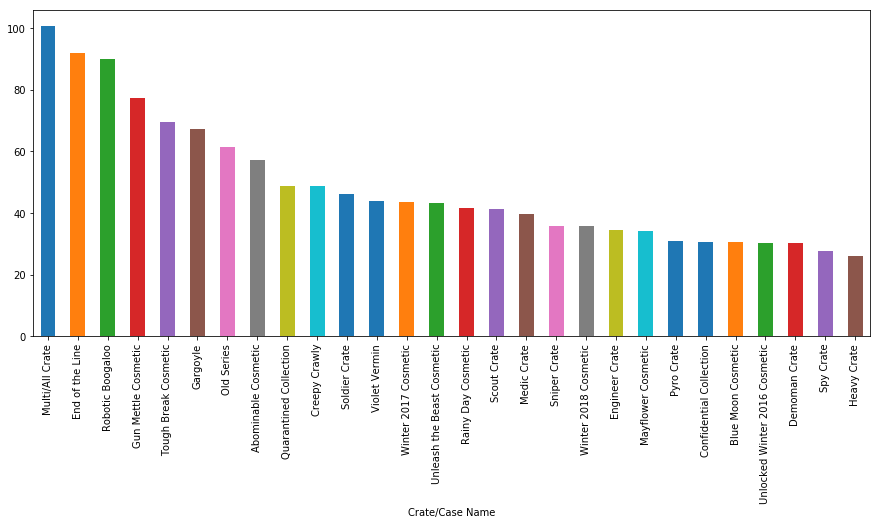

In [325]:
unboxing_df["Average Total Unbox Value"].sort_values(ascending = False).plot.bar(figsize = (15,6))

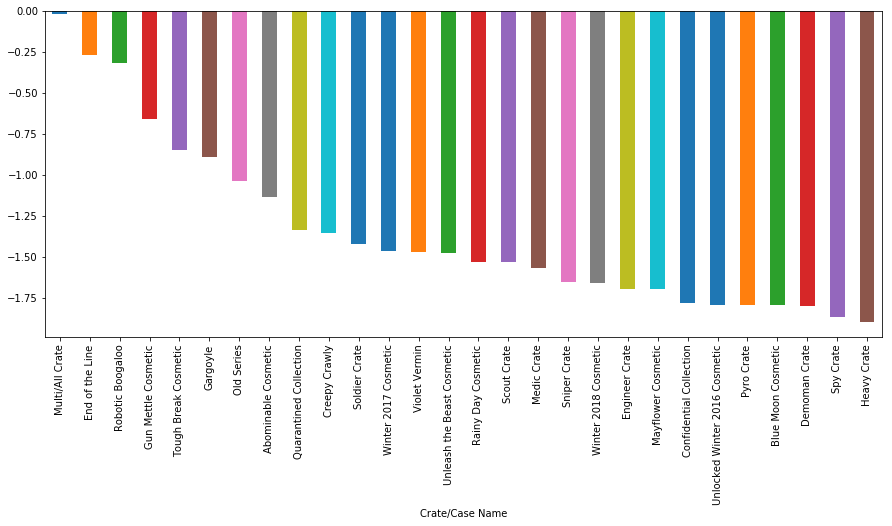

In [326]:
unboxing_df["Average Money Lost Per Unbox"].sort_values(ascending = False).plot.bar(figsize = (15,6))

## What about Halloween?

In [333]:
results_halloween = []

for crate in crates:
    unboxing_result = simulate_unboxing(crate,halloween = True)
    results_halloween.append([crate,unboxing_result[0],unboxing_result[1],unboxing_result[2],unboxing_result[3],unboxing_result[4]])
                   
unboxing_halloween_df = pd.DataFrame(results_halloween)

In [334]:
unboxing_halloween_df = unboxing_halloween_df.rename(columns={0: "Crate/Case Name",1:"Average Hat Unbox Value",2:"Average Taunt Unbox Value",
                           3:"Num Hats Unboxed",4:"Num Taunts Unboxed",5:"Average Money Lost Per Unbox"}).set_index("Crate/Case Name")

In [335]:
unboxing_halloween_df["Average Total Unbox Value"] = unboxing_halloween_df.apply(
    lambda row: (row["Average Hat Unbox Value"] + row["Average Taunt Unbox Value"]) if not pd.isnull(row["Average Taunt Unbox Value"]) else row["Average Hat Unbox Value"],
    axis=1)

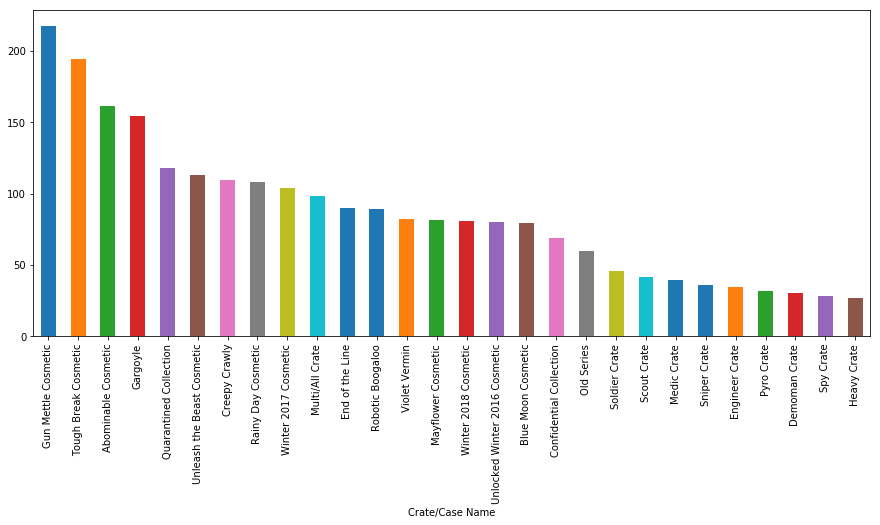

In [336]:
unboxing_halloween_df["Average Total Unbox Value"].sort_values(ascending = False).plot.bar(figsize = (15,6))

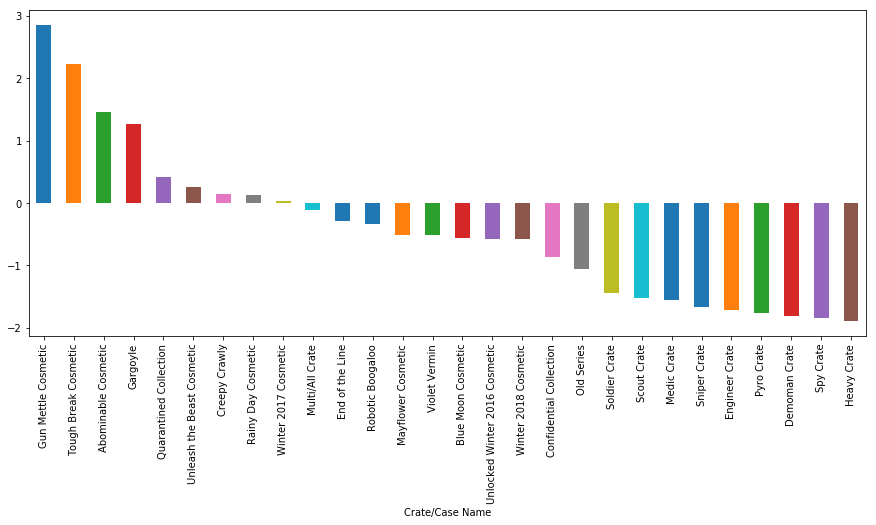

In [337]:
unboxing_halloween_df["Average Money Lost Per Unbox"].sort_values(ascending = False).plot.bar(figsize = (15,6))